# Offset-free linear MPC of a stirred-tank reactor

The mass and energy balances that characterize a reaction $\mathcal{A} \to \mathcal{B}$ occurring in the well-stirred chemical reactor in Fig.~\ref{fig:stirred_tank_reactor} is described by the following nonlinear state space model:

$$
\begin{equation}
\left\{
\begin{aligned}
&\dot{c}(t) = \frac{F_0 (c_0 - c(t))}{\pi r^2 h(t)} - k_0 \, c(t) \, e^{-\tfrac{E}{RT}}\\
&\dot{T}(t) = \frac{F_0 (T_0 - T(t))}{\pi r^2 h(t)} - \frac{\Delta H}{\rho C_p} k_0 c(t) \, e^{-\tfrac{E}{RT}} + \frac{2 U}{r \rho C_p}(T_c - T(t))\\
& \dot{h}(t) =  \frac{F_0 - F}{\pi r^2},
\end{aligned}
\right.
\end{equation}
$$

where $h$ is the level of the tank, $c$ the molar concentration of species $\mathcal{A}$ and $T$ represents the temperature of the reactor. The input control are $T_c$ and $F$, the coolant liquid temperature and the outlet flow-rate, respectively. Moreover, the inlet flow-rate $F_0$ acts as an unmeasured disturbance.
With the nominal values summarized in the table, the open-loop steady-state operating conditions are:

$$
c_{\textup{ref}} = 0.878 \, \text{[kmol/$\text{m}^3$]}, \; T_{\textup{ref}} = 324.5 \, \text{[K]}, \; h_{\textup{ref}} = 0.659 \, \text{[m]},
$$
$$
T_{c_\textup{ref}} = 300 \, \text{[K]}, \; F_{\textup{ref}} = 0.1 \, \text{[$\text{m}^3$/min]}.
$$ -->

| Parameter  | Nominal value  | Unit |
|------------|---------------|------|
| $F_0$   | 0.1           | $[m^3/\text{min}]$ |
| $T_0$   | 350           | $[K]$ |
| $c_0$   | 1             | $[kmol/m^3]$ |
| $r$     | 0.219         | $[m]$ |
| $k_0$   | $7.2 \times 10^{10}$ | $[\text{min}^{-1}]$ |
| $E/R$   | 8750          | $[K]$ |
| $U$     | 54.94         | $[\text{kJ}/(\text{min} \cdot m^2 \cdot K)]$ |
| $\rho$  | 1000          | $[\text{kg}/m^3]$ |
| $C_p$   | 0.239         | $[\text{kJ}/(\text{kg} \cdot K)]$ |
| $\Delta H$ | $-5 \times 10^4$ | $[\text{kJ}/\text{kmol}]$ |

By introducing the following measurable state variables, control inputs and disturbance
	$$
	x = \left[\begin{array}{c}
	c - c_{\textup{ref}}\\
	T - T_{\textup{ref}}\\
	h - h_{\textup{ref}}
	\end{array}
	\right], \; u = \left[\begin{array}{c}
	T_c - T_{c_{\textup{ref}}}\\
	F-F_{\textup{ref}}\\
	\end{array}
	\right], \; p = F_0 - F_{0_{\textup{ref}}},
	$$
	linearize  the nonlinear system around the steady-state operating conditions and discretize by using a sampling time of $1 \, \text{[min]}$ to get:
	$$
	\left\{
	\begin{aligned}
		&x(k+1) = A x(k) + B u(k) + B_{\textup{p}} p\\
		&y(k) = C x(k),
	\end{aligned}
	\right.
	$$
	with the following numerical values
	$$
	A = \left[\begin{array}{ccc}
	0.2682 &  -0.0034 &  -0.0073\\
	9.6985 &   \phantom{-}0.3277  & -25.4364\\
	0    &     \phantom{-}0  &  \phantom{-}1
	\end{array}\right], \; 
	B = \left[\begin{array}{cc}
	-0.0054 &   \phantom{-}0.1655\\
	\phantom{-}1.2964  &  \phantom{-}97.8998\\
	\phantom{-}0  & -6.6368
	\end{array}\right]
	$$
	$$
	B_{\textup{p}} = \left[\begin{array}{c}
   -0.1174\\
	\phantom{-}69.7264\\
	\phantom{-}6.6368
	\end{array}\right], \; C = I_3.
	$$




Let us design the controller to remove the offset. We begin by solving the following optimization problem to compute the infinite horizon optimal cost and control law for the unconstrained system
$$
\mathbb{P}^{\textup{uc}}_\infty(x) \, : \, \min_{\boldsymbol{u}} \sum_{k = 0}^{\infty} \left(\|y(k)\|^2_Q + \|u(k)\|^2_R\right),
$$
with
$$
Q = \left[\begin{array}{ccc}
	1.2977    &     0    &     0\\
0   & 0   &      0\\
0    &     0  &  2.3027
\end{array}
\right], \, R = \left[\begin{array}{ccc}
0 & 0\\
0 & 100
\end{array}
\right].
$$

In [1]:
import numpy as np
from control import dare
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True)

A = np.array([
    [0.2682, -0.0034, -0.0073],
    [9.6985, 0.3277, -25.4364],
    [0., 0., 1.]
])
B = np.array([
    [-0.0054, 0.1655],
    [1.2964, 97.8998],
    [0., -6.6368]
])
Bp = np.array([-0.1174, 69.7264, 6.6368])

C = np.eye(3)
nx = A.shape[0]
nu = B.shape[1]

Q = np.array([
    [1.2977, 0., 0.],
    [0., 0., 0.],
    [0., 0., 2.3027]
])
R = np.array([
    [0., 0.],
    [0., 100.]
])

P_inf, _, K_inf = dare(A, B, Q, R)
K_inf = -K_inf
print(f"P_inf:\n {P_inf}")
print(f"K_inf:\n {K_inf}")

P_inf:
 [[ 1.298  0.     0.   ]
 [ 0.    -0.    -0.   ]
 [ 0.    -0.     3.711]]
K_inf:
 [[49.667 -0.63   1.513]
 [-0.     0.     0.093]]


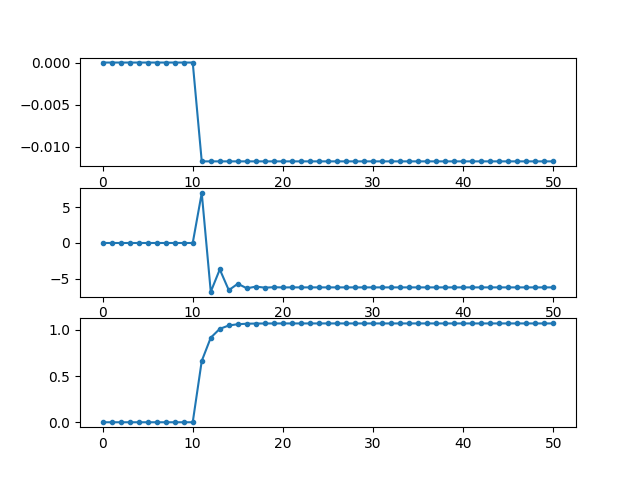

In [12]:
num_sim_steps  = 50
ps = np.ones(num_sim_steps)
ps[:10] = 0
ps[10:] *= 0.1
x0 = np.array([0., 0., 0.])
x_hist = np.zeros((num_sim_steps + 1, nx))
x_hist[0] = x0
for k in range(num_sim_steps):
    x = x_hist[k]
    u = K_inf @ x
    x_next = A @ x + B @ u + Bp * ps[k]
    x_hist[k+1] = x_next
    
%matplotlib ipympl
fig, ax = plt.subplots(3, 1)
ax[0].plot(x_hist[:, 0], '-o', label='x1', markersize=3)
ax[1].plot(x_hist[:, 1], '-o', label='x2', markersize=3)
ax[2].plot(x_hist[:, 2], '-o', label='x3', markersize=3)
plt.show()

### First trial
- Model the disturbance $d$ with two integrating output disturbances on the two state variables $c$ and $h$.

$$
C_d = \begin{bmatrix}
    1 & 0 \\
    0 & 0 \\
    0 & 1
\end{bmatrix} \quad
B_d = 0
$$

- Simulate the response of the closed-loop system after a $10\%$ increase in the inlet flow-rate $F_0$ at time $t = 10$ [min]. Use the linearized model for the plant model. 

- Determine if there are any steady offset on the outputs.

In [3]:
# nd = 2
# Cd = np.array([
#     [1., 0.],
#     [0., 0.],
#     [0., 1.]
# ])
# Bd = np.zeros((nx, nd))

nd = 3
Bd = np.zeros((nx, nd))
Bd[:, 2] = B[:, 1]
Cd = np.array([
    [1., 0., 0.],
    [0., 0., 0.],
    [0., 1., 0.]
])

A_aug = np.block([
    [A, Bd],
    [np.zeros((nd, nx)), np.eye(nd)]
])  
B_aug = np.vstack([B, np.zeros((nd, nu))])
C_aug = np.hstack([C, Cd])
nx_aug = A_aug.shape[0]
print(f"A_aug:\n {A_aug}")
print(f"B_aug:\n {B_aug}")
print(f"C_aug:\n {C_aug}")

# Detectability test
detec = np.linalg.matrix_rank(
    np.vstack([np.eye(nx + nd) - A_aug, C_aug])
)
print(f"Rank of the detectability matrix: {detec}")
if detec < nx + nd:
    print("The system is not detectable")

A_aug:
 [[  0.268  -0.003  -0.007   0.      0.      0.166]
 [  9.698   0.328 -25.436   0.      0.     97.9  ]
 [  0.      0.      1.      0.      0.     -6.637]
 [  0.      0.      0.      1.      0.      0.   ]
 [  0.      0.      0.      0.      1.      0.   ]
 [  0.      0.      0.      0.      0.      1.   ]]
B_aug:
 [[-0.005  0.166]
 [ 1.296 97.9  ]
 [ 0.    -6.637]
 [ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.     0.   ]]
C_aug:
 [[1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0.]]
Rank of the detectability matrix: 6


In [4]:
from scipy.signal import place_poles

# Define desired eigenvalues (observer pole placements)
# eigenplace = np.array([-0.3188, 0.6763, 0.3933 + 0.1810j, 0.3933 - 0.1810j, 0])

eigenplace = [0.5437 + 0.9125j, 0.5437 - 0.9125j, -0.3122, 0.1263, 0.5485, 0.6854];


# Compute observer gain matrix L
place_result = place_poles(A_aug.T, C_aug.T, eigenplace)
L = place_result.gain_matrix.T

# Extract Lx and Ld
Lx = L[:nx, :]
Ld = L[nx:, :]

In [5]:
num_sim_steps  = 50
ps = np.ones(num_sim_steps)
ps[:10] = 0.
ps[10:] *= 0.1
x0 = np.array([0., 0., 0.])
x_hist = np.zeros((num_sim_steps + 1, nx))
x_hist[0] = x0

xhat_hist = np.zeros((num_sim_steps, nx))
dhat_hist = np.zeros((num_sim_steps, nd))
xhat_ = np.zeros(nx)
dhat_ = np.zeros(nd)

H = np.array([
    [1., 0., 0.], 
    [0., 0., 1.],
])
G = np.block([
    [np.eye(nx) - A, -B],
    [H @ C, np.zeros((H.shape[0], nu))]
])
Ginv = np.linalg.inv(G) # G is invertible!

yset = np.array([0., 0., 0.])

for k in range(num_sim_steps):
    x = x_hist[k]
    
    # Measurement
    y = C @ x
    
    # State estimation
    ey = y - C @ xhat_ - Cd @ dhat_
    xhat = xhat_ + Lx @ ey
    dhat = dhat_ + Ld @ ey
    xhat_hist[k] = xhat
    dhat_hist[k] = dhat
    
    # Target selection    
    qs = Ginv @ np.hstack([Bd @ dhat, H @ (yset - Cd @ dhat)])
    xs = qs[:nx]
    us = qs[nx:]
    
    # Implement LQR
    u = K_inf @ (xhat - xs) + us
    
    # Simulation
    x_next = A @ x + B @ u + Bp * ps[k]
    x_hist[k+1] = x_next

    # Advance state estimates
    xhat_ = A @ xhat_hist[k] + B @ u + Bd @ dhat_hist[k] 
    dhat_ = dhat_hist[k]
    

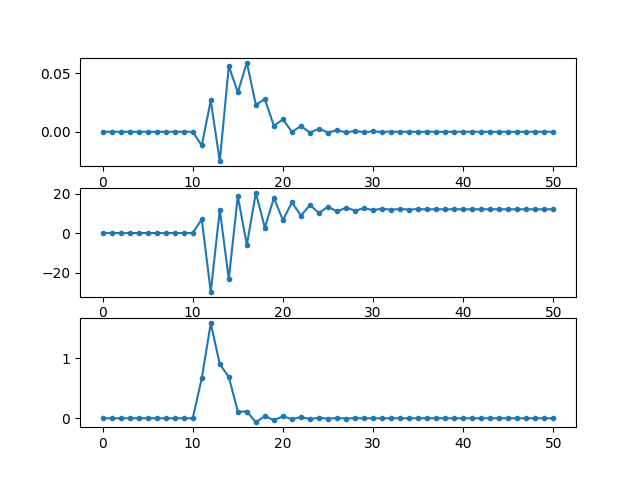

In [11]:
fig, ax = plt.subplots(3, 1)
ax[0].plot(x_hist[:, 0], '-o', label='x1', markersize=3)
ax[1].plot(x_hist[:, 1], '-o', label='x2', markersize=3)
ax[2].plot(x_hist[:, 2], '-o', label='x3', markersize=3)
plt.show()